# Application à la théorie de l'approximation
Dans cette première partie, on a une fonction $f:\mathbb R^n \rightarrow \mathbb R^q$ qui n'est connue que sur un certain nombre de points $n_{data}$. L'objectif est d'approximer cette fonction $f$ en dehors des points qui sont connus. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Neural as Neur

# Première application 
Ici $f$ est une fonction de $[0,1]$ dans $\mathbb{R}$ donnée par 
$x\mapsto \sin(6\pi |x|^{3/2}) +x^2$. Les données d'entrées $x_i$ sont les 256 points répartis uniforméments sur $[0,1]$ et les données de sorties sont les 256 réels donnés par $y_i=f(x_i)$. créez ces données dans un tableau `x` et `y` respectivement.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def original_function(x):
    return np.sin(6 * np.pi * np.power(np.abs(x), 1.5)) + x**2

In [4]:
X = np.random.uniform(size=[1, 256])
Y = original_function(X)
x_sorted = np.sort(X[0, :])
y_sorted = original_function(x_sorted)

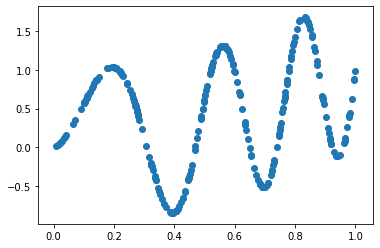

In [5]:
plt.scatter(x_sorted, y_sorted)
plt.show()

La fonction d'activation que nous allons utiliser est la fonction
$$x\mapsto \frac{1}{1+e^{-x}}$$
Implémentez cette fonction d'activation ainsi que sa dérivée dans la classe `Sigmoid`.



In [6]:
import Neural_corr as Neur
L=Neur.Sigmoid()
x2=np.array([0,3,2])
print(L.forward(x2))
print(L.backward(x2))
# Vous devez trouver
# [0.5        0.95257413 0.88079708]
# (None, array([0.        , 0.13552998, 0.20998717]))

[0.5        0.95257413 0.88079708]
(None, array([0.        , 0.13552998, 0.20998717]))


# Approximation par réseau de neurones profond
Nous allons construire 2 réseaux de neurones, le premier, noté `N` sera une couche Dense de taille $(1,12)$ suivi d'une sigmoïde et d'une couche dense $(12,1)$. Ce réseau de Neurone sera l'approximation de notre fonction $f$. Nous allons aussi créer un réseau de neurone noté `N_a` qui sera `N` suivi d'une couche de perte en norme $L^2$. Nous nous servirons de `N_a` pour l'optimisation. Créez ces deux réseaux de neurones et utilisez `N_a` pour lancer un algorithme de gradient à pas fixe avec $2000$ itérations, en faisant attention à bien régler le pas (vous verrez c'est quasiment impossible). Votre algorithme doit sortir l'évolution de la fonction objectif le long des itérations. Vous afficherez aussi le plit des vraies données et des prédictions du réseau de Neurone.

## Verification numerique du gradient

In [7]:
# Verification numerique du gradient
np.random.seed(13)

In [8]:
# Verification pour les valeurs de x

h = 1e-5
x = np.random.randn(1, 1)
Y = original_function(x)

N=Neur.Network([Neur.Dense(1,12),Neur.Sigmoid(),Neur.Dense(12,1)])
N_a=Neur.Network([N,Neur.Loss_L2(Y)])

f_x_plus_h = N_a.forward(x+h)
f_x = N_a.forward(x)
num_deriv = (f_x_plus_h - f_x) / h
theor_deriv = N_a.backward(None)[1]
print(num_deriv - theor_deriv, num_deriv, theor_deriv)


[[-1.82167367e-06]] -1.5543421228780827 [[-1.5543403]]


In [9]:
# Verification pour les parametres internes

theta = N_a.get_params()
d = np.random.randn(len(theta), 1)
d = d / np.linalg.norm(d)
d = d[:, 0]

fx = N_a.forward(x)
theor_grad = np.dot(N_a.backward(None)[0], d)

N_a.set_params(theta + h*d)
fx_plus_h = N_a.forward(x)
num_grad = (fx_plus_h - fx) / h
print(theor_grad - num_grad, theor_grad, num_grad)



-3.2112182195564998e-06 1.722313877729769 1.7223170889479886


## Approximation

In [10]:
X = np.random.uniform(size=[1, 256])
Y = original_function(X)
x_sorted = np.sort(X[0, :])
y_sorted = original_function(x_sorted)

In [11]:
np.random.seed(13)
N=Neur.Network([Neur.Dense(1,12),Neur.Sigmoid(),Neur.Dense(12,1)])
N_a=Neur.Network([N,Neur.Loss_L2(Y)])

In [12]:
def Grad_desc(NN, X, alpha, theta_0, eps=1e-6, max_iter=2000):
    NN.set_params(theta_0)
    loss = [NN.forward(X)]
    nb_iter = 0
    theta = theta_0
    while (loss[-1] > eps) and (nb_iter < max_iter):
        grad = NN.backward(None)[0]
        theta = theta - alpha*grad
        NN.set_params(theta)
        loss.append(NN.forward(X))
        nb_iter += 1
    return loss
        
    

In [13]:
Y_before = N.forward(X)

In [14]:
theta_0 = np.random.randn(N_a.nb_params)
alpha = 0.00005
loss = Grad_desc(N_a, X, alpha, theta_0)

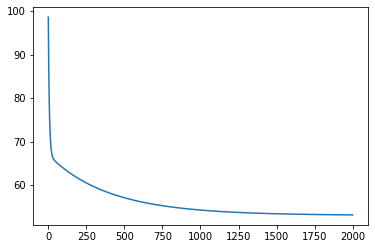

In [15]:
plt.plot(loss)
plt.show()

In [16]:
Y_after = N.forward(X)
Y_real = original_function(X)
df = pd.DataFrame({'X':X[0], 'Y_before':Y_before[0], 
                   'Y_after':Y_after[0], 'Y_real':Y_real[0]})
df = df.sort_values('X')

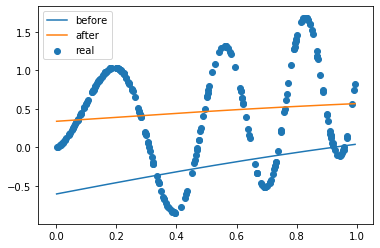

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.array(df['X']), np.array(df['Y_before']), label='before')
ax.plot(np.array(df['X']), np.array(df['Y_after']), label='after')
ax.scatter(np.array(df['X']), np.array(df['Y_real']), label='real')

plt.legend(loc='best')
plt.show()

Normalement vous ne devez pas avoir réussi à trouver le bon pas. Nous allons donc lancer un algorithme d'optimisation de `scipy` qui s'appelle `BFGS`. Si vous créez une fonction `func(u)` qui vous calcule le coût et une fonction `nablafunc(u)` qui vous rend le gradient de la fonction `func`, alors l'algorithme de `BFGS` que nous allons utiliser se lance avec :
`from scipy.optimize import minimize`
`res=minimize(func, u, method='BFGS', jac=nablafunc, options={'gtol': 1e-6, 'disp': True, 'maxiter': 2000})`
Dans le résultat `res`, il y a beaucoup d'information, mais le minimiseur est dans `res.x`.

In [18]:
from scipy.optimize import minimize

In [19]:
np.random.seed(13)
N=Neur.Network([Neur.Dense(1,12),Neur.Sigmoid(),Neur.Dense(12,1)])
N_a=Neur.Network([N,Neur.Loss_L2(Y)])


def func(u, NN, X):
    NN.set_params(u)
    return NN.forward(X)

def nablafunc(u, NN, X):
    NN.set_params(u)
    ignore = NN.forward(X)
    return NN.backward(None)[0]

# This is for verifying the gradient
u=N_a.get_params()
np.random.seed(42)
eps=1.e-4
c=func(u, N_a, X)
grad=nablafunc(u, N_a, X)
for i in range(4) :
    d=np.random.randn(u.shape[0])
    c2=func(u+eps*d, N_a, X)
    print((c2-c)/eps,np.dot(d,grad))


363.70257774265724 363.6619841723789
-595.5369679004718 -595.6450351155084
555.6767634766402 555.5723197745644
422.5315928802331 422.46541366515885


### Using BFGS algorithm

In [20]:
theta_0 = np.random.randn(N_a.nb_params)
N_a.set_params(theta_0)
Y_before = N.forward(X)
max_nb_attempts = 10
nb_attemps = 0
res = minimize(func, u, args=(N_a, X), method='BFGS', 
               jac=nablafunc, options={'gtol': 1e-6, 
                                       'disp':True, 
                                       'maxiter': 2000})
best_sol = res



         Current function value: 0.000551
         Iterations: 2000
         Function evaluations: 2250
         Gradient evaluations: 2250


In [21]:
best_sol.fun, best_sol.x, best_sol.success

(0.0005505815237490092,
 array([  9.73443684,  -1.47450822,  26.25556205, -20.06355229,
          4.89932189,  -1.30201671, -13.95805529, -19.6613895 ,
         17.06422722,  -4.14681567,  11.93185113, -21.42445325,
          1.49144731,   0.47643784, -14.35919744,  13.51531175,
         -3.42669076,   3.44456067,  23.55709825,  17.36304253,
         24.46047216,   3.47052557,  -4.04732331,  13.06134139,
        -11.17209634, -36.44927838,  -1.65088913,  13.11237162,
         52.59324376,  34.17933177, -24.52275697,  22.83949663,
         27.56516496, -30.78763853, -22.58876625,   9.95774752,
        -21.88311321]),
 False)

In [26]:
theta = best_sol.x
N_a.set_params(theta)
Y_after = N.forward(X)
Y_real = original_function(X)
df = pd.DataFrame({'X':X[0], 'Y_before':Y_before[0], 
                   'Y_after':Y_after[0], 'Y_real':Y_real[0]})
df = df.sort_values('X')

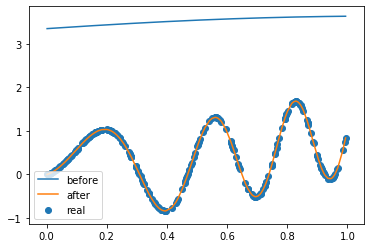

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.array(df['X']), np.array(df['Y_before']), label='before')
ax.plot(np.array(df['X']), np.array(df['Y_after']), label='after')
ax.scatter(np.array(df['X']), np.array(df['Y_real']), label='real')

plt.legend(loc='best')
plt.show()

### Using Nelder-Mead algorithm

In [28]:
theta_0 = np.random.randn(N_a.nb_params)
N_a.set_params(theta_0)
Y_before = N.forward(X)
max_nb_attempts = 2000
nb_attemps = 0
res = minimize(func, theta_0, args=(N_a, X))
best_sol = res

    

In [29]:
res.success

False

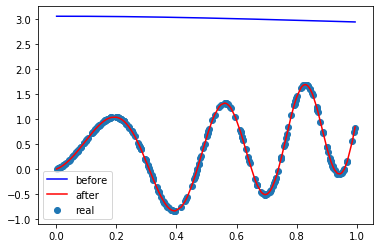

In [34]:
theta = res.x
N_a.set_params(theta)

Y = N.forward(X)
Y_real = original_function(X)
df = pd.DataFrame({'X':X[0], 'Y_before':Y_before[0], 
                   'Y_after':Y[0], 'Y_real':Y_real[0]})
df = df.sort_values('X')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.array(df['X']), np.array(df['Y_before']), 
        '-b', label='before')
ax.plot(np.array(df['X']), np.array(df['Y_after']), '-r',
        label='after')
ax.scatter(np.array(df['X']), np.array(df['Y_real']), label='real')

plt.legend(loc='best')
plt.show()